<a href="https://colab.research.google.com/github/danigallegdup/NUS-Stock-Data/blob/main/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction using LSTM
This project aims to predict stock prices using historical data and Long Short-Term Memory (LSTM) neural networks.

## Data Loading and Preprocessing

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [10]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Load the dataset (had to make a shortcut from "Shared with Me" to MyDrive)
sp500=pd.read_csv('/content/drive/MyDrive/cs3244_data/ETFs/spy.us.txt')
sp500.drop(columns={'OpenInt','Volume'}, inplace=True)
# Create empty lists to store the new data
dates = []
prices = []
price_types = []

# Iterate through the DataFrame
for index, row in sp500.iterrows():
  date = row['Date']
  open_price = row['Open']
  high_price = row['High']
  low_price = row['Low']
  close_price = row['Close']

  # Append the data to the lists
  dates.extend([date] * 4)  # Repeat the date 4 times
  prices.extend([open_price, high_price, low_price, close_price])
  price_types.extend(['open', 'high', 'low', 'close'])

# Create a new DataFrame
sp500 = pd.DataFrame({'Date': dates, 'Price': prices, 'Type of Price': price_types})

In [12]:
# Group the DataFrame by Date and Type of Price
grouped = sp500.groupby(['Date', 'Type of Price'])

# Calculate the average price for each date and type
avg_prices = grouped['Price'].mean().reset_index()

# Create a dictionary to store the average high and low prices for each date
avg_high_low = {}

# Iterate through the average prices
for index, row in avg_prices.iterrows():
  date = row['Date']
  price_type = row['Type of Price']
  price = row['Price']

  if date not in avg_high_low:
    avg_high_low[date] = {}

  if price_type == 'high' or price_type == 'low':
    avg_high_low[date][price_type] = price

# Iterate through the DataFrame and replace high and low prices with the average
for index, row in sp500.iterrows():
  date = row['Date']
  price_type = row['Type of Price']

  if price_type == 'high' or price_type == 'low' and date in avg_high_low:
    sp500.loc[index, 'Price'] = avg_high_low[date][price_type]


In [13]:
# Create a new DataFrame to store the modified data
new_sp500 = pd.DataFrame(columns=['Date', 'Price', 'Type of Price'])

# Iterate through the DataFrame
i = 0
while i < len(sp500):
  row = sp500.iloc[i]
  if row['Type of Price'] == 'high':
    # Check if the next row exists and is 'low'
    if i + 1 < len(sp500) and sp500.iloc[i + 1]['Type of Price'] == 'low':
      # Calculate the average of the high and low prices
      average_price = (row['Price'] + sp500.iloc[i + 1]['Price']) / 2
      # Add a new row with the average price and label 'average'
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [average_price], 'Type of Price': ['average']})], ignore_index=True)
      i += 2  # Skip the next row (low)
    else:
      # If the next row is not 'low', keep the current row as it is
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
      i += 1
  else:
    # If the current row is not 'high', keep it as it is
    new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
    i += 1

# Replace the original sp500 DataFrame with the modified one
sp500 = new_sp500
sp500

<ipython-input-13-90077ebfbdb0>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)


,Date,Price,Type of Price
0,2005-02-25,104.770,open
1,2005-02-25,105.340,average
2,2005-02-25,105.790,close
3,2005-02-28,105.550,open
4,2005-02-28,105.120,average
...,...,...,...
9598,2017-11-09,257.375,average
9599,2017-11-09,258.170,close
9600,2017-11-10,257.730,open
9601,2017-11-10,257.790,average


## Neural Network Architecture

In [16]:
print(sp500) # test case

# Preparing data for LSTM (Use 'Close' prices for simplicity)
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500.set_index('Date', inplace=True)

            Date    Price Type of Price
0     2005-02-25  104.770          open
1     2005-02-25  105.340       average
2     2005-02-25  105.790         close
3     2005-02-28  105.550          open
4     2005-02-28  105.120       average
...          ...      ...           ...
9598  2017-11-09  257.375       average
9599  2017-11-09  258.170         close
9600  2017-11-10  257.730          open
9601  2017-11-10  257.790       average
9602  2017-11-10  258.090         close

[9603 rows x 3 columns]


In [17]:
# Use only 'Close' prices for prediction
data = sp500[sp500['Type of Price'] == 'close']['Price'].values
data = data.reshape(-1, 1)

In [18]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [20]:
# Define lookback period (e.g., use the past 60 days of data to predict the next day)
lookback = 60
X_train = []
y_train = []


for i in range(lookback, len(scaled_data)):
    X_train.append(scaled_data[i-lookback:i, 0])
    y_train.append(scaled_data[i, 0])

In [21]:
# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [22]:
# Reshape data to be [samples, time steps, features] for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [23]:
# Define the LSTM Model
model = Sequential()

In [24]:
# LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Fully connected layer
model.add(Dense(units=1))  # Output layer for predicting the next price

In [26]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
model.summary()  # To see the architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model Using Prepared Dataset

In [28]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X_train) * 0.8)
X_test = X_train[train_size:]
y_test = y_train[train_size:]
X_train = X_train[:train_size]
y_train = y_train[:train_size]

In [29]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.0254
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 1.8048e-04
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - loss: 1.8353e-04
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - loss: 1.8137e-04
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 1.7627e-04
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.6742e-04
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 1.6206e-04
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 1.6502e-04
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 1.4548e-04
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 1.4945e-04


In [30]:
# Predicting on the test data
predicted_stock_price = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [31]:
# Invert scaling to get actual stock prices
predicted_stock_price = scaler.inverse_transform(predicted_stock_price.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

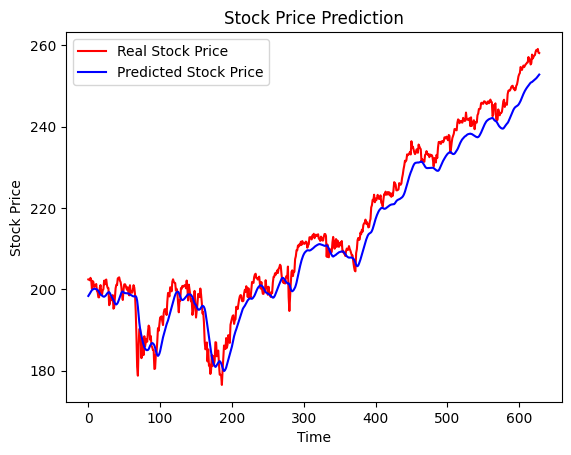

In [32]:
# Evaluate the model performance by plotting the results
import matplotlib.pyplot as plt

plt.plot(y_test, color='red', label='Real Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Key Points:
- We split the dataset into **80% training** and **20% testing**.
- The model is trained using **10 epochs** and a **batch size of 32**. You can increase these numbers to improve the model’s learning but it may take longer.
- After training, the model’s predictions are plotted against the real stock prices for comparison.

### Notes:
- **Normalization**: We normalize the stock prices to the range of 0 to 1 using `MinMaxScaler` before training the model, as LSTM networks generally perform better with normalized data.
- **Lookback Window**: In this case, we use a lookback period of 60 days to predict the next day’s price. You can adjust the lookback window to tune performance.



Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 1.5066e-04 - val_loss: 1.5702e-04
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 1.4647e-04 - val_loss: 1.5821e-04
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 1.4357e-04 - val_loss: 1.4536e-04
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 1.2344e-04 - val_loss: 2.0374e-04
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 1.3698e-04 - val_loss: 1.4232e-04
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 1.3650e-04 - val_loss: 2.0616e-04
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 1.1703e-04 - val_loss: 1.7700e-04
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 1.4345e-04 - val_loss: 1.4945e-04
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 1.4223e-04 - val_loss: 1.4679e-04
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1.2566e-04 - val_loss: 1.9244e-04


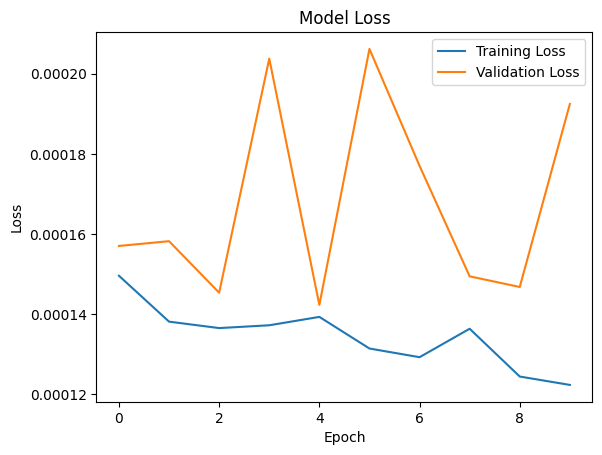

In [34]:
# Train the model with validation split
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()